# Kaggle Contest - Dog Breed Identification

Determine the breed of a dog in an image.

数据集特性

- 来自 Stanford Dog Dataset, 本身也是 ImageNet DataSet 的子集。http://vision.stanford.edu/aditya86/ImageNetDogs/

- 训练集10222张图片，测试集10357张图片。

- 图片包含具有120种品种的狗。

In [1]:
import os
import sys
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm

## 1. 导入训练集标签

#### 具体流程
- 导入训练集图像文件名及其品种
- 对图像类型进行onehot编码
- 数据探索
    - 训练集10222，测试集10357
    - 分类一共120种
    - 每个品种最多有126张图片，最少有66张图片
    - 平均每一个品种有85张图片

In [47]:
train_name = os.listdir('./train')
test_name = os.listdir('./test')
train_size = len(train_name)
test_size = len(test_name)
print("Train: %d, Test: %d" % (train_size, test_size))

Train: 10222, Test: 10357


In [46]:
labels = pd.read_csv('labels.csv')
test_labels = pd.read_csv('sample_submission.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [91]:
# 获得所有品种的名称列表
breeds = set(labels['breed'])
print("Total Dog Breeds:", len(breeds))
breeds = list(breeds)

Total Dog Breeds: 120


In [94]:
# 对图像类型进行onehot编码
Y_train = np.zeros((train_size, len(breeds)), dtype=np.uint8)
for i in range(train_size):
    onehot = breeds.index(labels['breed'][i])
    Y_train[i][onehot] = 1

for i in range(5):
    print(breeds[np.argmax(Y_train[i])])

boston_bull
dingo
pekinese
bluetick
golden_retriever


In [5]:
# 建立双向映射
id2breed = {}
breed2id = {}
for _, row in labels.iterrows():
    idx, breed = row['id'], row['breed']
    id2breed[idx] = breed
    if breed not in breed2id:
        breed2id[breed] = []
    breed2id[breed].append(idx)

In [11]:
count = [len(breed2id[x]) for x in breeds]
print("Data for Each Breed - Min: %d, Max: %d, Avg: %.2f" % (min(count), max(count), np.average(count)))

Data for Each Breed - Min: 66, Max: 126, Avg: 85.18


## 2. 导入数据集

#### 具体流程：

- 数据探索：图像尺寸分布平均值为 386 * 443
- 考虑到预训练模型的输入尺寸都是224，先设定载入尺寸为224看后期训练效果
- 按 `labels.csv` 的文件顺序载入训练集至内存
- 按 `sample_submission.csv` 的文件顺序载入测试集至内存
- 从载入完的图像中随机抽取看看效果

In [16]:
imgs = []
for i in tqdm(range(train_size)):
    img = cv2.imread('./train/%s.jpg' % labels['id'][i])
    imgs.append(img)

100%|█████████████████████████████████████████████████████| 10222/10222 [00:20<00:00, 496.54it/s]


Height * Width (Average): 386.75 * 443.33


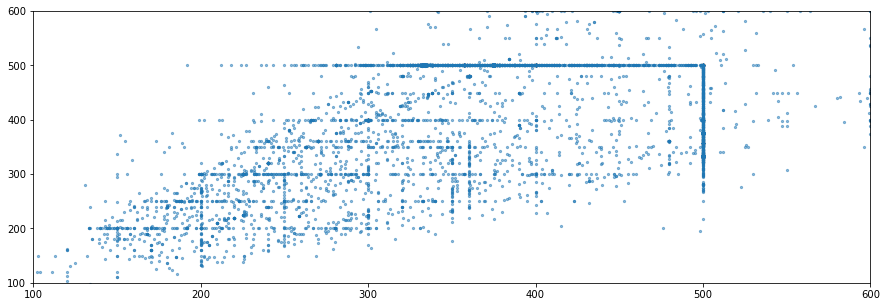

In [42]:
height = []
width = []
for img in imgs:
    height.append(img.shape[0])
    width.append(img.shape[1])
print("Height * Width (Average): %.2f * %.2f" % (np.average(height), np.average(width)))
plt.figure(figsize=[15, 5])
plt.scatter(height, width, s=5, alpha=0.5)
plt.xlim([100, 600])
plt.ylim([100, 600])
plt.show()

In [51]:
shape = 224
train = np.zeros((train_size, shape, shape, 3), dtype=np.uint8)
test = np.zeros((test_size, shape, shape, 3), dtype=np.uint8)
for i in tqdm(range(train_size)):
    img = cv2.imread('./train/%s.jpg' % labels['id'][i])
    img = cv2.resize(img, dsize=(shape, shape))
    img = img[:, :, ::-1]
    train[i] = img
    
for i in tqdm(range(test_size)):
    img = cv2.imread('./test/%s.jpg' % test_labels['id'][i])
    img = cv2.resize(img, dsize=(shape, shape))
    img = img[:, :, ::-1]
    test[i] = img

100%|█████████████████████████████████████████████████████| 10357/10357 [00:25<00:00, 402.33it/s]


In [64]:
print('Training Data Size = %.2f GB' % (sys.getsizeof(train)/1024**3))
print('Testing Data Size = %.2f GB' % (sys.getsizeof(test)/1024**3))

Training Data Size = 1.43 GB
Testing Data Size = 1.45 GB


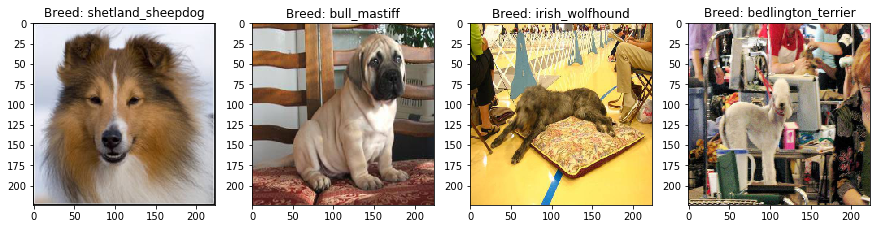

In [62]:
rand_size = 4
rand_id = np.random.choice(range(train_size), rand_size)
plt.figure(figsize=(15, 5))
for i in range(rand_size):
    plt.subplot(1, rand_size, i + 1)
    plt.imshow(train[rand_id[i]])
    plt.title("Breed: %s" % labels['breed'][rand_id[i]])
plt.show()

## 3. 预训练模型导出特征向量

#### 具体操作流程

- 用每个预训练模型（仅使用卷积层部分）对训练集和测试集的图片进行特征提取
- 将计算得到的特征向量导出为文件方便后期直接调用
- 从文件导入特征向量，将不同模型的特征向量以串联方式融合为一个特征向量：np.concatenate(xxx, axis=1)

In [80]:
import h5py
from keras.applications import inception_v3, xception, resnet50
from keras.applications import InceptionV3, Xception, ResNet50
from keras.models import load_model, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Lambda

def export_gap(MODEL, train, test, preprocess=None):
    x = Input((shape, shape, 3))
    if preprocess:
        x = Lambda(preprocess)(x)
    model = MODEL(input_tensor=x, weights='imagenet', include_top=False, pooling='avg')

    train_gap = model.predict(train, batch_size=128)
    test_gap = model.predict(test, batch_size=128)
    
    with h5py.File("gap_%s.h5" % MODEL.__name__, 'w') as f:
        f.create_dataset('train', data=train_gap)
        f.create_dataset('test', data=test_gap)

In [73]:
export_gap(InceptionV3, train, test, preprocess=inception_v3.preprocess_input)

In [74]:
export_gap(Xception, train, test, preprocess=xception.preprocess_input)

In [79]:
train = []
test = []
for gapfile in ['gap_InceptionV3.h5', 'gap_Xception.h5']:
    with h5py.File(gapfile, 'r') as f:
        train.append(np.array(f['train']))
        test.append(np.array(f['test']))
        
print('Feature Vector Shape for Model #0:', train[0].shape)
X_train = np.concatenate(train, axis=1)
X_test = np.concatenate(test, axis=1)
print('Feature Vector Shape after model fusion:', X_train.shape)

Feature Vector Shape for Model #0: (10222, 2048)
Feature Vector Shape after Merging models: (10222, 4096)


## 4. 建立融合模型

In [96]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, shuffle=True, test_size=0.2, random_state=42)
print(X_train.shape)

(8177, 4096)


In [103]:
inputs = Input(shape=(X_train.shape[1],))
y = Dropout(0.25)(inputs)
y = Dense(120, activation='softmax')(y)

model_fusion = Model(inputs=inputs, outputs=y, name='Fusion')
model_fusion.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model_fusion.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 4096)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               491640    
Total params: 491,640
Trainable params: 491,640
Non-trainable params: 0
_________________________________________________________________


In [105]:
model_fusion.fit(x=X_train, y=y_train, batch_size=128, epochs=10, validation_data=(X_val, y_val))

Train on 8177 samples, validate on 2045 samples
Epoch 1/10
8177/8177 [==============================] - ETA: 0s - loss: 0.2400 - acc: 0.937 - ETA: 0s - loss: 0.2020 - acc: 0.945 - ETA: 0s - loss: 0.1934 - acc: 0.949 - ETA: 0s - loss: 0.1924 - acc: 0.949 - ETA: 0s - loss: 0.1923 - acc: 0.947 - ETA: 0s - loss: 0.1948 - acc: 0.945 - 0s - loss: 0.1943 - acc: 0.9457 - val_loss: 0.4878 - val_acc: 0.8450
Epoch 2/10
8177/8177 [==============================] - ETA: 0s - loss: 0.1328 - acc: 0.984 - ETA: 0s - loss: 0.1604 - acc: 0.959 - ETA: 0s - loss: 0.1704 - acc: 0.954 - ETA: 0s - loss: 0.1750 - acc: 0.951 - ETA: 0s - loss: 0.1745 - acc: 0.951 - ETA: 0s - loss: 0.1783 - acc: 0.951 - 0s - loss: 0.1780 - acc: 0.9519 - val_loss: 0.4845 - val_acc: 0.8460
Epoch 3/10
8177/8177 [==============================] - ETA: 0s - loss: 0.1402 - acc: 0.968 - ETA: 0s - loss: 0.1741 - acc: 0.951 - ETA: 0s - loss: 0.1686 - acc: 0.952 - ETA: 0s - loss: 0.1653 - acc: 0.953 - ETA: 0s - loss: 0.1646 - acc: 0.954 - 